# Data Retrieval - Climate data

## CRU Data

In [1]:
import gzip
import os
import shutil
import tempfile
import netCDF4
from netCDF4 import Dataset
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
lon = 16.363449
lat = 48.210033

In [9]:
val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
fold_n = '/Users/davidschildberger/03_LeWagon_Datasets/CRU_raw_data_2021/'

In [10]:
def get_filename(feat_name):
    fi_n = os.listdir(fold_n)
    fi_n.remove('.DS_Store')
    for i in fi_n: 
        if(feat_name in i) : 
            return i

In [11]:
def open_netcdf(fname):
    with gzip.open((fold_n+fname), 'rb') as f:
        tmp = tempfile.NamedTemporaryFile(delete=False)
        shutil.copyfileobj(f, tmp)

        f.close()
        tmp.close()
        
        data = netCDF4.Dataset(tmp.name)
        os.unlink(tmp.name)
    return data

In [12]:
def retrieve_CRU_data(datatype, year, lon, lat):
    
    data = open_netcdf(get_filename(datatype)) # 0 = 'cld'
    
    year_in_month = (year-1901)*12
    
    c_lat = int(round(np.interp(lat, [-90, 90], [0, 360])))  # check order of values here
    c_lon = int(round(np.interp(lon, [-180, 180], [0, 720])))
    
    temp_dat_date = data.variables[datatype][year_in_month:year_in_month+12,c_lat,c_lon].data
    return temp_dat_date

In [13]:
sp_dat = retrieve_CRU_data('cld', 1980, lon, lat)
sp_dat, sp_dat.mean()

(array([80.5     , 70.9     , 78.5     , 65.9     , 63.2     , 68.1     ,
        65.3     , 57.9     , 52.100002, 65.4     , 78.6     , 71.1     ],
       dtype=float32),
 68.12499)

In [439]:
def retrieve_all_features_mean_CRU_data(year, lon, lat):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    mean_val = []
    for val in val_nam_list:
        mean_val.append(retrieve_CRU_data(val, year, lon, lat).mean())
    return dict(zip(val_nam_list, mean_val))

In [440]:
retrieve_all_features_mean_CRU_data(1980, lon, lat)

{'cld': 67.53333,
 'dtr': 7.6083336,
 'frs': 9.624166,
 'pet': 1.9583334,
 'pre': 49.899998,
 'tmn': 5.066667,
 'tmp': 8.841666,
 'tmx': 12.675,
 'vap': 9.216666,
 'wet': 12.561666}

### Bio Variables / slow?!

In [295]:
## BIO1 = Annual Mean Temperature
def bio_1_annual_mean_temp(year, lon, lat):
    temp_mean = 'tmp'
    return retrieve_CRU_data(temp_mean, year, lon, lat).mean()

In [296]:
bio_1_annual_mean_temp(1980, lon, lat)

8.841666

In [298]:
## Mean Diurnal Range (Mean of monthly (max temp - min temp))
def bio_2_mean_diurnal_range(year, lon, lat):
    t_min = retrieve_CRU_data('tmn', year, lon, lat)
    t_max = retrieve_CRU_data('tmx', year, lon, lat)
    diurnal = t_max-t_min
    return diurnal.mean()

In [299]:
bio_2_mean_diurnal_range(1980, lon, lat)

7.6083336

In [402]:
## BIO3 = Isothermality (BIO2/BIO7) (×100)
def bio_3_isothermality(year, lon, lat):
    val = bio_2_mean_diurnal_range(year, lon, lat)/bio_7_temp_range(year, lon, lat)
    return val

In [403]:
bio_3_isothermality(1980, lon, lat)

0.24863835

In [311]:
## BIO4 = Temperature Seasonality (standard deviation ×100)
def bio_4_temperature_seasonality(year, lon, lat):
    t_mean = retrieve_CRU_data('tmp', year, lon, lat)
    return np.std(t_mean)

In [312]:
bio_4_temperature_seasonality(1980, lon, lat)

7.3900223

In [314]:
## BIO5 = Max Temperature of Warmest Month
def bio_5_max_temp_of_max_month(year, lon, lat):
    t_max = retrieve_CRU_data('tmx', year, lon, lat)
    return np.max(t_max)

In [316]:
bio_5_max_temp_of_max_month(1980, lon, lat)

24.9

In [328]:
## BIO6 = Min Temperature of Coldest Month
def bio_6_min_temp_of_min_month(year, lon, lat):
    t_min = retrieve_CRU_data('tmn', year, lon, lat)
    return np.min(t_min)

In [329]:
bio_6_min_temp_of_min_month(1980, lon, lat)

-5.7000003

In [330]:
## BIO7 = Temperature Annual Range (BIO5-BIO6)
def bio_7_temp_range(year, lon, lat):
    rang_temp = bio_5_max_temp_of_max_month(year, lon, lat)-bio_6_min_temp_of_min_month(year, lon, lat)
    return rang_temp

In [331]:
bio_7_temp_range(1980, lon, lat)

30.6

In [351]:
## BIO8 = Mean Temperature of Wettest Quarter
def bio_8_mean_temp_wet_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()

In [352]:
bio_8_mean_temp_wet_q(1980, lon, lat)

4.1666665

In [353]:
## BIO9 = Mean Temperature of Driest Quarter
def bio_9_mean_temp_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()

In [354]:
bio_9_mean_temp_dry_q(1980, lon, lat)

17.7

In [340]:
## BIO10 = Mean Temperature of Warmest Quarter
def bio_10_mean_temp_warm_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return temp_wet[st:st+3].mean()

In [341]:
bio_10_mean_temp_warm_q(1980, lon, lat)

17.7

In [343]:
## BIO11 = Mean Temperature of Coldest Quarter
def bio_11_mean_temp_cold_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return temp_wet[st:st+3].mean()

In [344]:
bio_11_mean_temp_cold_q(1980, lon, lat)

1.1

In [349]:
## BIO12 = Annual Precipitation
def bio_12_annual_prec(year, lon, lat):
    return retrieve_CRU_data('pre', year, lon, lat).sum()

In [350]:
bio_12_annual_prec(1980, lon, lat)

598.8

In [361]:
## BIO13 = Precipitation of Wettest Month
def bio_13_prec_wet_mo(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    max_index=np.argmax(temp_wet)
    return retrieve_CRU_data('pre', year, lon, lat)[max_index]

In [362]:
bio_13_prec_wet_mo(1980, lon, lat)

75.1

In [363]:
## BIO14 = Precipitation of Driest Month
def bio_14_prec_dry_mo(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    min_index=np.argmin(temp_wet)
    return retrieve_CRU_data('pre', year, lon, lat)[min_index]

In [364]:
bio_14_prec_dry_mo(1980, lon, lat)

34.7

In [375]:
## BIO15 = Precipitation Seasonality (Coefficient of Variation)
def bio_15_prec_wet_mo(year, lon, lat):
    temp_pre = retrieve_CRU_data('pre', year, lon, lat)
    cv = lambda x: np.std(temp_pre, ddof=1) / np.mean(temp_pre) * 100
    return cv(temp_pre)

In [376]:
bio_15_prec_wet_mo(1980, lon, lat)

46.613526344299316

In [405]:
## BIO16 = Precipitation of Wettest Quarter
def bio_16_pre_wet_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [406]:
bio_16_pre_wet_q(1980, lon, lat)

57.333332

In [385]:
## BIO17 = Precipitation of Driest Quarter
def bio_17_pre_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [386]:
bio_17_pre_dry_q(1980, lon, lat)

47.766666

In [387]:
## BIO18  Precipitation of Warmest Quarter...
def bio_18_pre_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [388]:
bio_18_pre_dry_q(1980, lon, lat)

47.766666

In [419]:
## BIO19 = Precipitation of Coldest Quarter...
def bio_19_pre_cld_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [420]:
bio_19_pre_cld_q(1980, lon, lat)

28.200003

In [421]:
def get_bioclim_var(year, lon, lat):
    temp_li = []
    temp_li.append(bio_1_annual_mean_temp(year, lon, lat))
    temp_li.append(bio_2_mean_diurnal_range(year, lon, lat))
    temp_li.append(bio_3_isothermality(year, lon, lat))
    temp_li.append(bio_4_temperature_seasonality(year, lon, lat))
    temp_li.append(bio_5_max_temp_of_max_month(year, lon, lat))
    temp_li.append(bio_6_min_temp_of_min_month(year, lon, lat))
    temp_li.append(bio_7_temp_range(year, lon, lat))
    temp_li.append(bio_8_mean_temp_wet_q(year, lon, lat))
    temp_li.append(bio_9_mean_temp_dry_q(year, lon, lat))
    temp_li.append(bio_10_mean_temp_warm_q(year, lon, lat))
    temp_li.append(bio_11_mean_temp_cold_q(year, lon, lat))
    temp_li.append(bio_12_annual_prec(year, lon, lat))
    temp_li.append(bio_13_prec_wet_mo(year, lon, lat))
    temp_li.append(bio_14_prec_dry_mo(year, lon, lat))
    temp_li.append(bio_15_prec_wet_mo(year, lon, lat))
    temp_li.append(bio_16_pre_wet_q(year, lon, lat))
    temp_li.append(bio_17_pre_dry_q(year, lon, lat))
    temp_li.append(bio_18_pre_cld_q(year, lon, lat))
    temp_li.append(bio_19_pre_cld_q(year, lon, lat))
    return temp_li

In [422]:
get_bioclim_var(1980, lon, lat)

[8.841666,
 7.6083336,
 0.24863835,
 7.3900223,
 24.9,
 -5.7000003,
 30.6,
 4.1666665,
 17.7,
 17.7,
 1.1,
 598.8,
 75.1,
 34.7,
 46.613526344299316,
 57.333332,
 47.766666,
 28.200003,
 28.200003]

### Bio variables / optimized

In [ ]:
def retrieve_CRU_data_all(datatype, year):
    data = open_netcdf(get_filename(datatype))
    return data.variables[datatype][year_in_month:year_in_month+12,:,:].data

In [424]:
dat_t = retrieve_CRU_data_all('cld', 1980)
dat_t.shape

(12, 360, 720)

In [436]:
def retrieve_all_features_CRU_data(year):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    val_t = []
    for val in val_nam_list:
        val_t.append(retrieve_CRU_data_all(val, year))
    return np.array(val_t)

In [437]:
dat_ = retrieve_all_features_mean_CRU_data(1980)
dat_

array([[[[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         ...,
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36]],

        [[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         ...,
         [9.96921e+36, 9.96921e+36

In [438]:
dat_.shape

(10, 12, 360, 720)

In [448]:
def retrieve_all_features_all_years_CRU_data(year_start, year_stop):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    
    year_start_in_month = (year_start-1901)*12
    year_stop_in_month = (year_stop-1901)*12
    
    val_t = []
    for val in val_nam_list:
        data = open_netcdf(get_filename(val))
        val_t.append(data.variables[val][year_start_in_month:year_stop_in_month,:,:].data)
    return np.array(val_t)

In [451]:
dt = retrieve_all_features_all_years_CRU_data(1980,1982)
dt.shape

(10, 24, 360, 720)

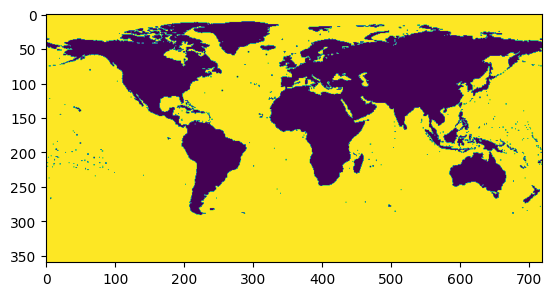

In [515]:
plt.imshow(np.flip(dt[0,0,:,:],0));

### Bio variables / individual features

In [14]:
## BIO1 = Annual Mean Temperature
def bio_1(year):
    val = 'tmp'
    data = open_netcdf(get_filename(val))
    
    year_in_month = (year-1901)*12
    
    d = data.variables[val][year_in_month:year_in_month+12,:,:].data.mean(axis=0)
    d[d > 50000] = np.nan
    res = np.flip(d,0)
    return res

In [15]:
b1 = bio_1(1980)
b1.shape

(360, 720)

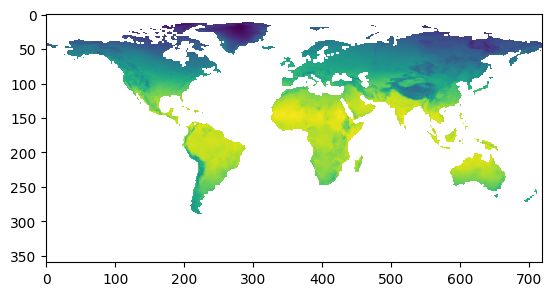

In [1269]:
plt.imshow(b1);

In [61]:
## Mean Diurnal Range (Mean of monthly (max temp - min temp))
def bio_2(year):
    data_tmn = open_netcdf(get_filename('tmn'))
    data_tmx = open_netcdf(get_filename('tmx'))
    year_in_month = (year-1901)*12
    
    t_min = data_tmn.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    t_max = data_tmx.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    t_min[t_min > 255] = np.nan
    t_max[t_max > 255] = np.nan
    d = t_max - t_min
    d = d.mean(axis=0)
    d[d > 50000] = np.nan
    res = np.flip(d,0)
    return res

In [1310]:
b2 = bio_2(1980)

In [1311]:
b2.shape

(360, 720)

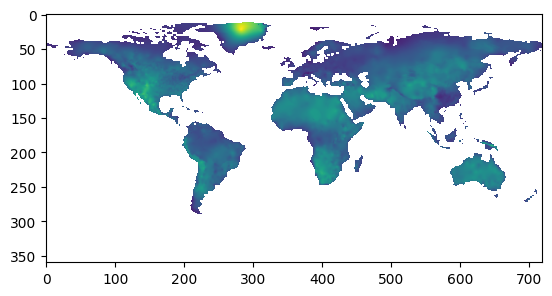

In [1312]:
plt.imshow(b2);

In [62]:
## BIO3 = Isothermality (BIO2/BIO7) (×100)
def bio_3(year):
    val = bio_2(year)/bio_7(year)
    val[val > 50000] = np.nan
    return val

In [1330]:
b3 = bio_3(1980)

In [1331]:
b3.shape

(360, 720)

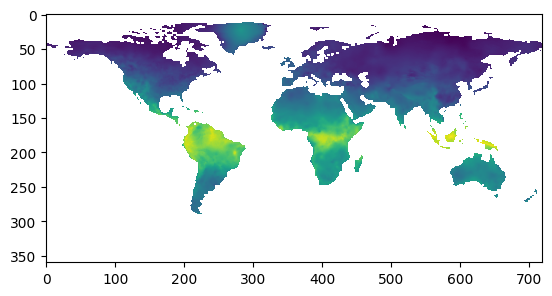

In [1332]:
plt.imshow(b3);

In [63]:
## BIO4 = Temperature Seasonality (standard deviation ×100)
def bio_4(year):
    data = open_netcdf(get_filename('tmp'))

    year_in_month = (year-1901)*12
    
    t_mp = data.variables['tmp'][year_in_month:year_in_month+12,:,:].data
    t_mp[t_mp > 50000] = np.nan
    res = np.std(t_mp, axis=0)
    res = np.flip(res,0)
    return res

In [1302]:
b4 = bio_4(1980)

In [1303]:
b4.shape

(360, 720)

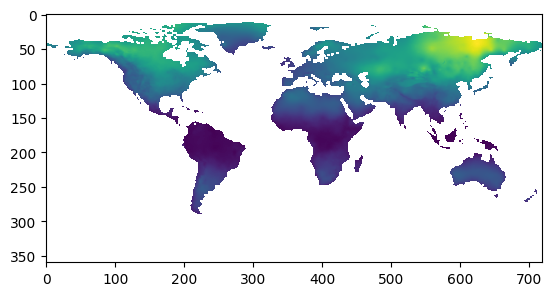

In [1304]:
plt.imshow(b4);

In [64]:
## BIO5 = Max Temperature of Warmest Month
def bio_5(year):
    data = open_netcdf(get_filename('tmx'))

    year_in_month = (year-1901)*12
    
    t_max = data.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    t_max[t_max > 50000] = np.nan
    res = np.max(t_max, axis=0)
    res = np.flip(res,0)
    return res

In [1298]:
b5 = bio_5(1980)

In [1299]:
b5.shape

(360, 720)

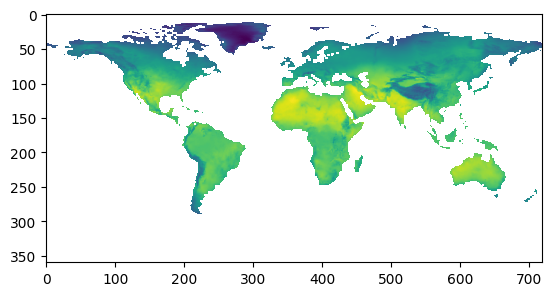

In [1300]:
plt.imshow(b5);

In [65]:
## BIO6 = Min Temperature of Coldest Month
def bio_6(year):
    data = open_netcdf(get_filename('tmn'))

    year_in_month = (year-1901)*12
    
    t_min = data.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    t_min[t_min > 50000] = np.nan
    res = np.min(t_min, axis=0)
    res = np.flip(res,0)
    return res

In [1293]:
b6 = bio_6(1980)

In [1294]:
b6.shape

(360, 720)

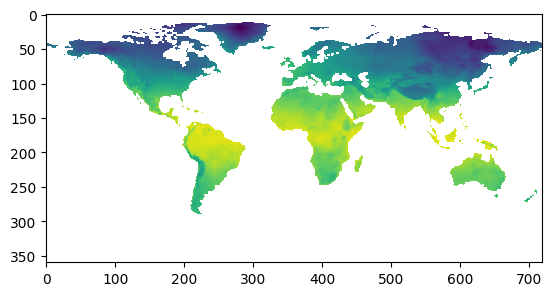

In [1296]:
plt.imshow(b6);

In [66]:
## BIO7 = Temperature Annual Range (BIO5-BIO6)
def bio_7(year):
    rang_temp = bio_5(1980)-bio_6(1980)
    rang_temp[rang_temp > 50000] = np.nan
    return rang_temp

In [1320]:
b7 = bio_7(1980)

In [1321]:
b7.shape

(360, 720)

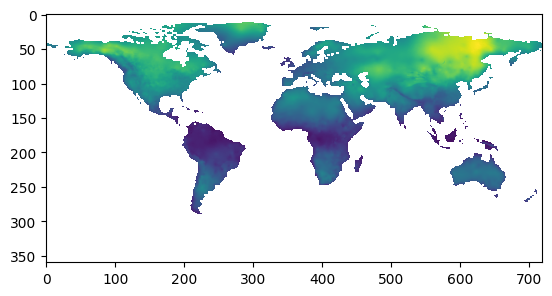

In [1322]:
plt.imshow(b7);

In [67]:
## BIO8 = Mean Temperature of Wettest Quarter
def bio_8(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1334]:
b8 = bio_8(1980)

In [1335]:
b8.shape

(360, 720)

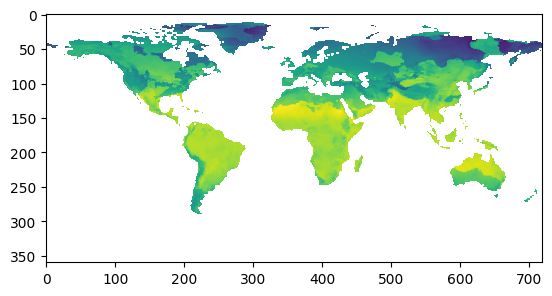

In [1336]:
plt.imshow(b8);

In [68]:
## BIO9 = Mean Temperature of Driest Quarter
def bio_9(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1338]:
b9 = bio_9(1980)

In [1339]:
b9.shape

(360, 720)

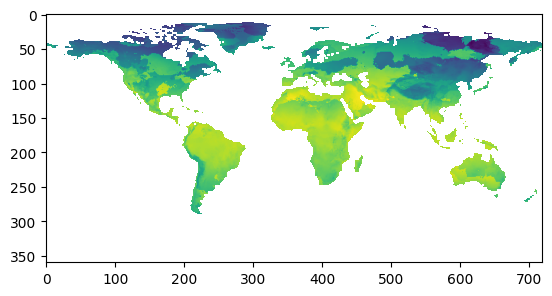

In [1340]:
plt.imshow(b9);

In [69]:
## BIO10 = Mean Temperature of Warmest Quarter
def bio_10(year):
    data_wet = open_netcdf(get_filename('tmx'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1342]:
b10 = bio_10(1980)

In [1343]:
b10.shape

(360, 720)

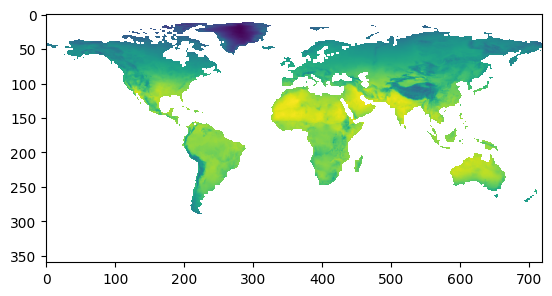

In [1344]:
plt.imshow(b10);

In [70]:
## BIO11 = Mean Temperature of Coldest Quarter
def bio_11(year):
    data_wet = open_netcdf(get_filename('tmn'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1350]:
b11 = bio_11(1980)

In [1351]:
b11.shape

(360, 720)

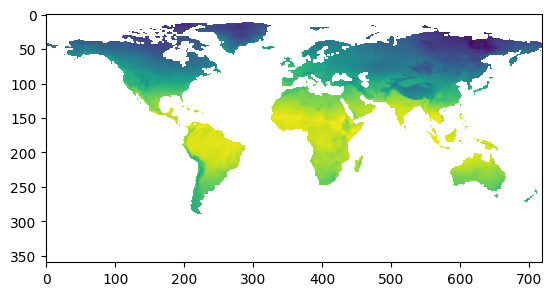

In [1352]:
plt.imshow(b11);

In [71]:
## BIO12 = Annual Precipitation
def bio_12(year):
    data_pre = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_pre.variables['pre'][year_in_month:year_in_month+12,:,:].data
    temp_wet[temp_wet > 50000000] = np.nan
    temp_wet = np.sum(temp_wet, axis=0)
    res = np.flip(temp_wet,0)
    return res

In [1354]:
b12 = bio_12(1980)

In [1355]:
b12.shape

(360, 720)

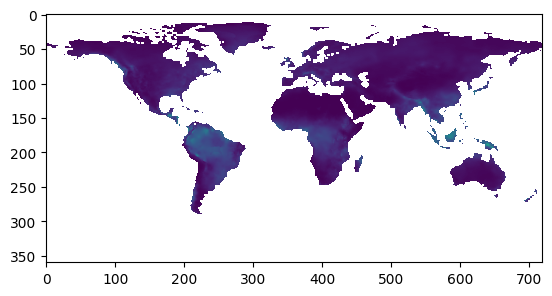

In [1356]:
plt.imshow(b12);

In [72]:
## BIO13 = Precipitation of Wettest Month
def bio_13(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    max_ind = np.argmax(temp_wet, axis=0)
        
    res = np.choose(max_ind, data_tmp.variables['pre'][year_in_month:year_in_month+12,:,:].data)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1358]:
b13 = bio_13(1980)

In [1359]:
b13.shape

(360, 720)

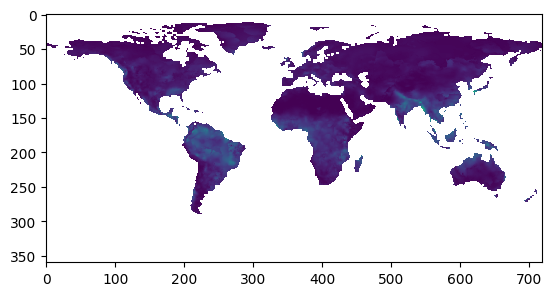

In [1360]:
plt.imshow(b13);

In [73]:
## BIO14 = Precipitation of Driest Month
def bio_14(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    min_ind = np.argmin(temp_wet, axis=0)
        
    res = np.choose(min_ind, data_tmp.variables['pre'][year_in_month:year_in_month+12,:,:].data)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1362]:
b14 = bio_14(1980)

In [1363]:
b14.shape

(360, 720)

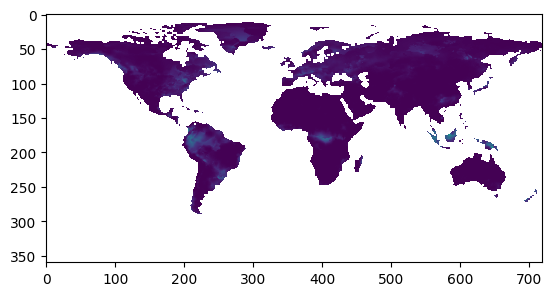

In [1364]:
plt.imshow(b14);

In [74]:
## BIO15 = Precipitation Seasonality (Coefficient of Variation)
def bio_15(year):
    val = 'pre'
    data = open_netcdf(get_filename(val))
    
    year_in_month = (year-1901)*12
    
    d = data.variables[val][year_in_month:year_in_month+12,:,:].data
    d[d > 500000] = np.nan
    cv = lambda x: np.std(d, ddof=1, axis=0) / np.mean(d, axis=0) * 100
    d = cv(d)
    res = np.flip(d,0)
    return res

In [1366]:
b15 = bio_15(1980)

/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_34377/2129893429.py:10: RuntimeWarning: invalid value encountered in divide
  cv = lambda x: np.std(d, ddof=1, axis=0) / np.mean(d, axis=0) * 100


In [1367]:
b15.shape

(360, 720)

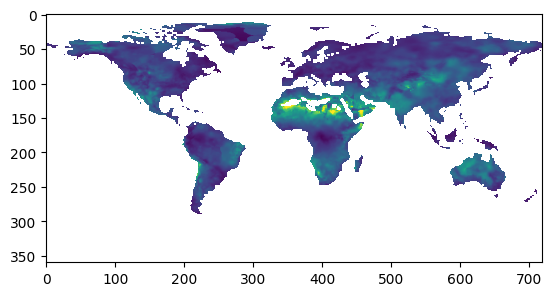

In [1368]:
plt.imshow(b15);

In [75]:
## BIO16 = Precipitation of Wettest Quarter
def bio_16(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    return res

In [1370]:
b16 = bio_16(1980)

In [1371]:
b16.shape

(360, 720)

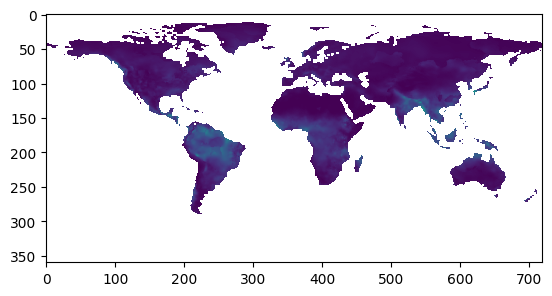

In [1372]:
plt.imshow(b16);

In [76]:
## BIO17 = Precipitation of Driest Quarter
def bio_17(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    return res

In [1374]:
b17 = bio_17(1980)

In [1375]:
b17.shape

(360, 720)

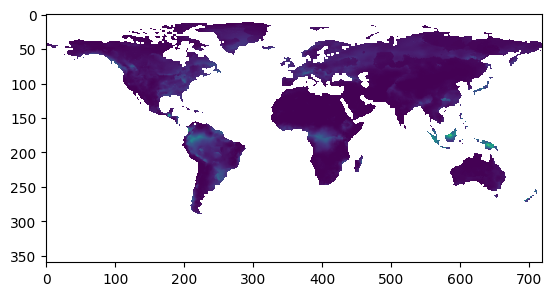

In [1376]:
plt.imshow(b17);

In [77]:
## BIO18  Precipitation of Warmest Quarter...
def bio_18(year):
    data_wet = open_netcdf(get_filename('tmp'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmp'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    return res

In [1378]:
b18 = bio_18(1980)

In [1379]:
b18.shape

(360, 720)

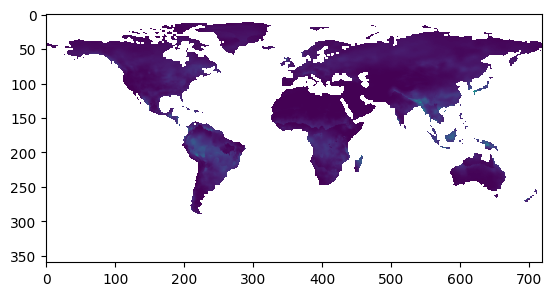

In [1380]:
plt.imshow(b18);

In [78]:
## BIO19 = Precipitation of Coldest Quarter...
def bio_19(year):
    data_wet = open_netcdf(get_filename('tmn'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    return res

In [1382]:
b19 = bio_19(1980)

In [1383]:
b19.shape

(360, 720)

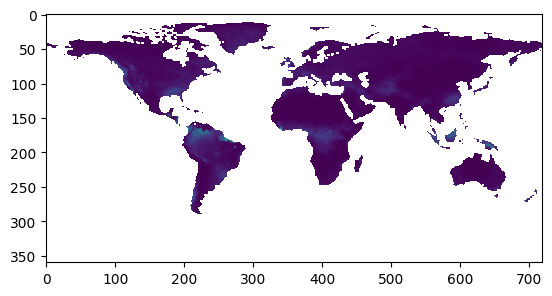

In [1384]:
plt.imshow(b19);

### Create and save bioclim files for each year

In [ ]:
for i in range(19):
    F"bio_{i}""

In [94]:
def create_and_save_bioclim():
    for i in range(20,122):
        st = 1901+i
        os.makedirs(f"../raw_data/bioclim/{st}")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_1.csv", 
                   bio_1(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_2.csv", 
                   bio_2(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_3.csv", 
                   bio_3(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_4.csv", 
                   bio_4(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_5.csv", 
                   bio_5(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_6.csv", 
                   bio_6(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_7.csv", 
                   bio_7(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_8.csv", 
                   bio_8(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_9.csv", 
                   bio_9(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_10.csv", 
                   bio_10(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_11.csv", 
                   bio_11(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_12.csv", 
                   bio_12(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_13.csv", 
                   bio_13(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_14.csv", 
                   bio_14(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_15.csv", 
                   bio_15(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_16.csv", 
                   bio_16(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_17.csv", 
                   bio_17(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_18.csv", 
                   bio_18(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_19.csv", 
                   bio_19(st), delimiter=",")

In [95]:
create_and_save_bioclim()

/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_53909/2129893429.py:10: RuntimeWarning: invalid value encountered in divide
  cv = lambda x: np.std(d, ddof=1, axis=0) / np.mean(d, axis=0) * 100
/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_53909/1907512179.py:8: RuntimeWarning: Mean of empty slice.
  d = data.variables[val][year_in_month:year_in_month+12,:,:].data.mean(axis=0)
/Users/davidschildberger/.pyenv/versions/3.10.6/envs/planetary_garden/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_53909/3630763923.py:12: RuntimeWarning: Mean of empty slice.
  d = d.mean(axis=0)
/Users/davidschildberger/.pyenv/versions/3.10.6/envs/planetary_garden/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidsch

ValueError: zero-size array to reduction operation maximum which has no identity

### Retrieve Bioclim Data for plants

In [170]:
def get_plant_features():
    df = pd.read_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/data_clean_subset_5_cont.csv", on_bad_lines='skip')
    #df = df[['gbifID', 'kingdom', 'species', 'scientificName', 'decimalLatitude', 'decimalLongitude','countryCode', 'year']]
    return df

In [1528]:
def get_bioclim_from_plants(df):
    df[['b1', 'b2', 'b3', 'b4', 'b5','b6','b7','b8','b9','b10','b11','b12','b13','b14',
            'b15','b16','b17','b18','b19']] = np.nan
    for i in range(len(df)):
        lat = df.loc[i, 'decimalLatitude']
        lon = df.loc[i, 'decimalLongitude']
        c_lat = int(round(np.interp(lat, [-89, 89], [359, 0])))  # check order of values here
        c_lon = int(round(np.interp(lon, [-179, 179], [1, 719])))
        df.loc[i, 'b1'] = b1[c_lat, c_lon]
        df.loc[i, 'b2'] = b2[c_lat, c_lon]
        df.loc[i, 'b3'] = b3[c_lat, c_lon]
        df.loc[i, 'b4'] = b4[c_lat, c_lon]
        df.loc[i, 'b5'] = b5[c_lat, c_lon]
        df.loc[i, 'b6'] = b6[c_lat, c_lon]
        df.loc[i, 'b7'] = b7[c_lat, c_lon]
        df.loc[i, 'b8'] = b8[c_lat, c_lon]
        df.loc[i, 'b9'] = b9[c_lat, c_lon]
        df.loc[i, 'b10'] = b10[c_lat, c_lon]
        df.loc[i, 'b11'] = b11[c_lat, c_lon]
        df.loc[i, 'b12'] = b12[c_lat, c_lon]
        df.loc[i, 'b13'] = b13[c_lat, c_lon]
        df.loc[i, 'b14'] = b14[c_lat, c_lon]
        df.loc[i, 'b15'] = b15[c_lat, c_lon]
        df.loc[i, 'b16'] = b16[c_lat, c_lon]
        df.loc[i, 'b17'] = b17[c_lat, c_lon]
        df.loc[i, 'b18'] = b18[c_lat, c_lon]
        df.loc[i, 'b19'] = b19[c_lat, c_lon]
    df.dropna(inplace=True)
    df.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/plant_data_inkl_bioclim.csv")
    return df

In [168]:
df = get_bioclim_from_plants(df_init)
df.head()

NameError: name 'get_bioclim_from_plants' is not defined

### Retrieve Bioclim Data for plants from files

In [229]:
dd = get_plant_features()

In [230]:
dd.head()

,Unnamed: 0,gbifID,decimalLongitude,decimalLatitude,kingdom,scientificName,countryCode,year
0,6,1320983475,-83.7478,35.63890,Animalia,"Plethodon ventralis Highton, 1997",US,1962.0
1,9,1322495249,102.3320,-5.40923,Animalia,"Sus scrofa Linnaeus, 1758",ID,1904.0
2,10,1322501794,119.8700,16.33000,Animalia,"Cypho zaps Gill, 2004",PH,1995.0
3,25,1317749830,-76.6091,36.06070,Animalia,"Lithobates palustris (LeConte, 1825)",US,NaN
4,27,1318143764,-69.2800,-12.83000,Animalia,"Leptodactylus didymus Heyer, García-Lopez & Ca...",PE,1990.0


In [231]:
dd.shape

(329185, 8)

In [232]:
dd = dd[dd['year']>1901]

In [233]:
dd.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
dd.dropna(inplace=True)
dd['year'] = dd['year'].astype('int')
dd.reset_index(inplace=True, drop=True)

In [234]:
dd.shape

(180691, 8)

In [235]:
dd['year'] = dd['year'].astype('int')

In [236]:
dd.drop(columns='Unnamed: 0', inplace=True)
dd

,gbifID,decimalLongitude,decimalLatitude,kingdom,scientificName,countryCode,year
0,1320983475,-83.747800,35.638900,Animalia,"Plethodon ventralis Highton, 1997",US,1962
1,1322495249,102.332000,-5.409230,Animalia,"Sus scrofa Linnaeus, 1758",ID,1904
2,1322501794,119.870000,16.330000,Animalia,"Cypho zaps Gill, 2004",PH,1995
3,1318143764,-69.280000,-12.830000,Animalia,"Leptodactylus didymus Heyer, García-Lopez & Ca...",PE,1990
4,1319377461,-66.974200,-15.789600,Plantae,Meibomia longiarticulata Rusby,BO,1921
...,...,...,...,...,...,...,...
180686,3314963922,150.866667,-35.050000,Animalia,"Australoecetes jervisi Just, 1985",AU,1984
180687,3314963949,170.166667,-42.166667,Animalia,"Runanga coxalis J.L.Barnard, 1961",NZ,1952
180688,3314965809,165.400000,-43.966667,Animalia,"Stenetrium abyssale Wolff, 1962",NZ,1952
180689,3314967046,157.033333,-33.433333,Animalia,"Mimoscina galbraithae Zeidler, 2012",AU,1929


#### Dumb version from .csv - Retrieve Bioclim Data for plants from files

In [237]:
def get_bioclim_from_plants_with_year(df):
    df[['b1', 'b2', 'b3', 'b4', 'b5','b6','b7','b8','b9','b10','b11','b12','b13','b14',
            'b15','b16','b17','b18','b19']] = np.nan
    for i in range(len(df)):
        print(i)
        
        lat = df.loc[i, 'decimalLatitude']
        lon = df.loc[i, 'decimalLongitude']
        year = int(df.loc[i, 'year'])
        c_lat = int(round(np.interp(lat, [-89, 89], [359, 0])))  # check order of values here
        c_lon = int(round(np.interp(lon, [-179, 179], [1, 719])))
        
        path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{year}/"
        
        filen = 'bio_1.csv'
        bio_1 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b1'] = bio_1[c_lat, c_lon]
        
        filen = 'bio_2.csv'
        bio_2 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b2'] = bio_2[c_lat, c_lon]
        
        filen = 'bio_3.csv'
        bio_3 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b3'] = bio_3[c_lat, c_lon]
        
        filen = 'bio_4.csv'
        bio_4 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b4'] = bio_4[c_lat, c_lon]
        
        filen = 'bio_5.csv'
        bio_5 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b5'] = bio_5[c_lat, c_lon]
        
        filen = 'bio_6.csv'
        bio_6 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b6'] = bio_6[c_lat, c_lon]
        
        filen = 'bio_7.csv'
        bio_7 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b7'] = bio_7[c_lat, c_lon]
        
        filen = 'bio_8.csv'
        bio_8 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b8'] = bio_8[c_lat, c_lon]
        
        filen = 'bio_9.csv'
        bio_9 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b9'] = bio_9[c_lat, c_lon]
        
        filen = 'bio_10.csv'
        bio_10 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b10'] = bio_10[c_lat, c_lon]
        
        filen = 'bio_11.csv'
        bio_11 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b11'] = bio_11[c_lat, c_lon]
        
        filen = 'bio_12.csv'
        bio_12 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b12'] = bio_12[c_lat, c_lon]
        
        filen = 'bio_13.csv'
        bio_13 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b13'] = bio_13[c_lat, c_lon]
        
        filen = 'bio_14.csv'
        bio_14 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b14'] = bio_14[c_lat, c_lon]
        
        filen = 'bio_15.csv'
        bio_15 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b15'] = bio_15[c_lat, c_lon]
        
        filen = 'bio_16.csv'
        bio_16 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b16'] = bio_16[c_lat, c_lon]
        
        filen = 'bio_17.csv'
        bio_17 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b17'] = bio_17[c_lat, c_lon]
        
        filen = 'bio_18.csv'
        bio_18 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b18'] = bio_18[c_lat, c_lon]
        
        filen = 'bio_19.csv'
        bio_19 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b19'] = bio_19[c_lat, c_lon]
        
    #df.dropna(inplace=True)
    #df.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/plant_data_inkl_bioclim.csv")
    return df

In [238]:
bio_clim_df = get_bioclim_from_plants_with_year(dd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


KeyboardInterrupt: 

#### Retrieve Bioclim Data for plants from files - .npy file

In [317]:
def get_plant_features():
    df = pd.read_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/data_clean_5_continent_Animal_plants.csv", on_bad_lines='skip')
    return df

In [318]:
dd_set = get_plant_features()

In [319]:
dd_set = dd_set[(dd_set['year']>=1901) & (dd_set['year']<=2021)]
dd_set.reset_index(inplace=True)

In [320]:
dd_set.head()

,index,gbifID,datasetKey,kingdom,phylum,class,order,family,genus,species,scientificName,verbatimScientificName,countryCode,locality,stateProvince,decimalLatitude,decimalLongitude,year
0,0,1807713417,2f676abc-4503-489e-8f0c-fcb6e1bc554b,Animalia,Arthropoda,Insecta,Coleoptera,Curculionidae,Andranthobius,Andranthobius setirostris,Andranthobius setirostris,Andranthobius setirostris,BR,Canaã do Carajás,Pará,-6.475556,-49.874167,2005
1,1,1807713566,2f676abc-4503-489e-8f0c-fcb6e1bc554b,Animalia,Arthropoda,Insecta,Coleoptera,Curculionidae,Andranthobius,Andranthobius setirostris,Andranthobius setirostris,Andranthobius setirostris,BR,Canaã do Carajás,Pará,-6.475556,-49.874167,2005
2,2,1807713573,2f676abc-4503-489e-8f0c-fcb6e1bc554b,Animalia,Arthropoda,Insecta,Coleoptera,Curculionidae,Andranthobius,Andranthobius setirostris,Andranthobius setirostris,Andranthobius setirostris,BR,Canaã do Carajás,Pará,-6.475556,-49.874167,2005
3,3,1807713712,2f676abc-4503-489e-8f0c-fcb6e1bc554b,Animalia,Arthropoda,Insecta,Coleoptera,Curculionidae,Andranthobius,Andranthobius setirostris,Andranthobius setirostris,Andranthobius setirostris,BR,Canaã do Carajás,Pará,-6.475556,-49.874167,2005
4,4,1807713469,2f676abc-4503-489e-8f0c-fcb6e1bc554b,Animalia,Arthropoda,Insecta,Coleoptera,Curculionidae,Andranthobius,Andranthobius setirostris,Andranthobius setirostris,Andranthobius setirostris,BR,Canaã do Carajás,Pará,-6.475556,-49.874167,2005


In [321]:
path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/"
filen = 'bioclim.npy'
bioclim = np.load(path+filen)

In [322]:
bioclim.shape

(121, 19, 360, 720)

In [332]:
def get_bioclim_from_plants(df):
    df[['b1', 'b2', 'b3', 'b4', 'b5','b6','b7','b8','b9','b10','b11','b12','b13','b14',
            'b15','b16','b17','b18','b19']] = np.nan
    
    path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/"
    filen = 'bioclim.npy'
    bioclim = np.load(path+filen)
    
    for i in range(len(df)):
        print(i)
        
        lat = df.loc[i, 'decimalLatitude']
        lon = df.loc[i, 'decimalLongitude']
        year = int(df.loc[i, 'year'])
        
        c_lat = int(round(np.interp(lat, [-89, 89], [359, 0])))  # check order of values here
        c_lon = int(round(np.interp(lon, [-179, 179], [1, 719])))
        
        for j in range(19):
            df.loc[i, f"b{j+1}"] = bioclim[year-1901, j, c_lat, c_lon]
        
    #df.dropna(inplace=True)
    df.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/data_inkl_bioclim.csv")
    return df

In [ ]:
get_bioclim_from_plants(dd_set)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511


4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221


5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999


8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589


10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
1046

12004
12005
12006
12007
12008
12009
12010
12011
12012
12013
12014
12015
12016
12017
12018
12019
12020
12021
12022
12023
12024
12025
12026
12027
12028
12029
12030
12031
12032
12033
12034
12035
12036
12037
12038
12039
12040
12041
12042
12043
12044
12045
12046
12047
12048
12049
12050
12051
12052
12053
12054
12055
12056
12057
12058
12059
12060
12061
12062
12063
12064
12065
12066
12067
12068
12069
12070
12071
12072
12073
12074
12075
12076
12077
12078
12079
12080
12081
12082
12083
12084
12085
12086
12087
12088
12089
12090
12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
12118
12119
12120
12121
12122
12123
12124
12125
12126
12127
12128
12129
12130
12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154
12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166
12167
12168
12169
1217

13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955
13956
13957
13958
13959
13960
13961
13962
13963
13964
13965
13966
13967
13968
13969
13970
13971
13972
13973
13974
13975
13976
13977
13978
13979
13980
13981
1398

16837
16838
16839
16840
16841
16842
16843
16844
16845
16846
16847
16848
16849
16850
16851
16852
16853
16854
16855
16856
16857
16858
16859
16860
16861
16862
16863
16864
16865
16866
16867
16868
16869
16870
16871
16872
16873
16874
16875
16876
16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
1700

18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19000
19001
19002
19003
19004
19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019
19020
19021
19022
19023
19024
19025
19026
19027
19028
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
19074
19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
19088
19089
19090
19091
19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
19102
19103
19104
19105
19106
19107
19108
19109
19110
19111
19112
19113
1911

20683
20684
20685
20686
20687
20688
20689
20690
20691
20692
20693
20694
20695
20696
20697
20698
20699
20700
20701
20702
20703
20704
20705
20706
20707
20708
20709
20710
20711
20712
20713
20714
20715
20716
20717
20718
20719
20720
20721
20722
20723
20724
20725
20726
20727
20728
20729
20730
20731
20732
20733
20734
20735
20736
20737
20738
20739
20740
20741
20742
20743
20744
20745
20746
20747
20748
20749
20750
20751
20752
20753
20754
20755
20756
20757
20758
20759
20760
20761
20762
20763
20764
20765
20766
20767
20768
20769
20770
20771
20772
20773
20774
20775
20776
20777
20778
20779
20780
20781
20782
20783
20784
20785
20786
20787
20788
20789
20790
20791
20792
20793
20794
20795
20796
20797
20798
20799
20800
20801
20802
20803
20804
20805
20806
20807
20808
20809
20810
20811
20812
20813
20814
20815
20816
20817
20818
20819
20820
20821
20822
20823
20824
20825
20826
20827
20828
20829
20830
20831
20832
20833
20834
20835
20836
20837
20838
20839
20840
20841
20842
20843
20844
20845
20846
20847
20848
2084

22204
22205
22206
22207
22208
22209
22210
22211
22212
22213
22214
22215
22216
22217
22218
22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229
22230
22231
22232
22233
22234
22235
22236
22237
22238
22239
22240
22241
22242
22243
22244
22245
22246
22247
22248
22249
22250
22251
22252
22253
22254
22255
22256
22257
22258
22259
22260
22261
22262
22263
22264
22265
22266
22267
22268
22269
22270
22271
22272
22273
22274
22275
22276
22277
22278
22279
22280
22281
22282
22283
22284
22285
22286
22287
22288
22289
22290
22291
22292
22293
22294
22295
22296
22297
22298
22299
22300
22301
22302
22303
22304
22305
22306
22307
22308
22309
22310
22311
22312
22313
22314
22315
22316
22317
22318
22319
22320
22321
22322
22323
22324
22325
22326
22327
22328
22329
22330
22331
22332
22333
22334
22335
22336
22337
22338
22339
22340
22341
22342
22343
22344
22345
22346
22347
22348
22349
22350
22351
22352
22353
22354
22355
22356
22357
22358
22359
22360
22361
22362
22363
22364
22365
22366
22367
22368
22369
2237

23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
2391

25600
25601
25602
25603
25604
25605
25606
25607
25608
25609
25610
25611
25612
25613
25614
25615
25616
25617
25618
25619
25620
25621
25622
25623
25624
25625
25626
25627
25628
25629
25630
25631
25632
25633
25634
25635
25636
25637
25638
25639
25640
25641
25642
25643
25644
25645
25646
25647
25648
25649
25650
25651
25652
25653
25654
25655
25656
25657
25658
25659
25660
25661
25662
25663
25664
25665
25666
25667
25668
25669
25670
25671
25672
25673
25674
25675
25676
25677
25678
25679
25680
25681
25682
25683
25684
25685
25686
25687
25688
25689
25690
25691
25692
25693
25694
25695
25696
25697
25698
25699
25700
25701
25702
25703
25704
25705
25706
25707
25708
25709
25710
25711
25712
25713
25714
25715
25716
25717
25718
25719
25720
25721
25722
25723
25724
25725
25726
25727
25728
25729
25730
25731
25732
25733
25734
25735
25736
25737
25738
25739
25740
25741
25742
25743
25744
25745
25746
25747
25748
25749
25750
25751
25752
25753
25754
25755
25756
25757
25758
25759
25760
25761
25762
25763
25764
25765
2576

27749
27750
27751
27752
27753
27754
27755
27756
27757
27758
27759
27760
27761
27762
27763
27764
27765
27766
27767
27768
27769
27770
27771
27772
27773
27774
27775
27776
27777
27778
27779
27780
27781
27782
27783
27784
27785
27786
27787
27788
27789
27790
27791
27792
27793
27794
27795
27796
27797
27798
27799
27800
27801
27802
27803
27804
27805
27806
27807
27808
27809
27810
27811
27812
27813
27814
27815
27816
27817
27818
27819
27820
27821
27822
27823
27824
27825
27826
27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
2791

29627
29628
29629
29630
29631
29632
29633
29634
29635
29636
29637
29638
29639
29640
29641
29642
29643
29644
29645
29646
29647
29648
29649
29650
29651
29652
29653
29654
29655
29656
29657
29658
29659
29660
29661
29662
29663
29664
29665
29666
29667
29668
29669
29670
29671
29672
29673
29674
29675
29676
29677
29678
29679
29680
29681
29682
29683
29684
29685
29686
29687
29688
29689
29690
29691
29692
29693
29694
29695
29696
29697
29698
29699
29700
29701
29702
29703
29704
29705
29706
29707
29708
29709
29710
29711
29712
29713
29714
29715
29716
29717
29718
29719
29720
29721
29722
29723
29724
29725
29726
29727
29728
29729
29730
29731
29732
29733
29734
29735
29736
29737
29738
29739
29740
29741
29742
29743
29744
29745
29746
29747
29748
29749
29750
29751
29752
29753
29754
29755
29756
29757
29758
29759
29760
29761
29762
29763
29764
29765
29766
29767
29768
29769
29770
29771
29772
29773
29774
29775
29776
29777
29778
29779
29780
29781
29782
29783
29784
29785
29786
29787
29788
29789
29790
29791
29792
2979

32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
3224

33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
33659
33660
33661
33662
33663
33664
33665
33666
33667
33668
33669
33670
33671
33672
33673
33674
33675
33676
33677
33678
33679
33680
33681
33682
33683
33684
33685
33686
33687
33688
33689
33690
33691
33692
33693
33694
33695
33696
33697
33698
33699
33700
33701
33702
33703
33704
33705
33706
33707
33708
33709
33710
33711
33712
33713
33714
33715
33716
33717
33718
33719
33720
33721
33722
33723
33724
33725
33726
33727
33728
33729
33730
33731
33732
33733
33734
33735
3373

35379
35380
35381
35382
35383
35384
35385
35386
35387
35388
35389
35390
35391
35392
35393
35394
35395
35396
35397
35398
35399
35400
35401
35402
35403
35404
35405
35406
35407
35408
35409
35410
35411
35412
35413
35414
35415
35416
35417
35418
35419
35420
35421
35422
35423
35424
35425
35426
35427
35428
35429
35430
35431
35432
35433
35434
35435
35436
35437
35438
35439
35440
35441
35442
35443
35444
35445
35446
35447
35448
35449
35450
35451
35452
35453
35454
35455
35456
35457
35458
35459
35460
35461
35462
35463
35464
35465
35466
35467
35468
35469
35470
35471
35472
35473
35474
35475
35476
35477
35478
35479
35480
35481
35482
35483
35484
35485
35486
35487
35488
35489
35490
35491
35492
35493
35494
35495
35496
35497
35498
35499
35500
35501
35502
35503
35504
35505
35506
35507
35508
35509
35510
35511
35512
35513
35514
35515
35516
35517
35518
35519
35520
35521
35522
35523
35524
35525
35526
35527
35528
35529
35530
35531
35532
35533
35534
35535
35536
35537
35538
35539
35540
35541
35542
35543
35544
3554

36790
36791
36792
36793
36794
36795
36796
36797
36798
36799
36800
36801
36802
36803
36804
36805
36806
36807
36808
36809
36810
36811
36812
36813
36814
36815
36816
36817
36818
36819
36820
36821
36822
36823
36824
36825
36826
36827
36828
36829
36830
36831
36832
36833
36834
36835
36836
36837
36838
36839
36840
36841
36842
36843
36844
36845
36846
36847
36848
36849
36850
36851
36852
36853
36854
36855
36856
36857
36858
36859
36860
36861
36862
36863
36864
36865
36866
36867
36868
36869
36870
36871
36872
36873
36874
36875
36876
36877
36878
36879
36880
36881
36882
36883
36884
36885
36886
36887
36888
36889
36890
36891
36892
36893
36894
36895
36896
36897
36898
36899
36900
36901
36902
36903
36904
36905
36906
36907
36908
36909
36910
36911
36912
36913
36914
36915
36916
36917
36918
36919
36920
36921
36922
36923
36924
36925
36926
36927
36928
36929
36930
36931
36932
36933
36934
36935
36936
36937
36938
36939
36940
36941
36942
36943
36944
36945
36946
36947
36948
36949
36950
36951
36952
36953
36954
36955
3695

38471
38472
38473
38474
38475
38476
38477
38478
38479
38480
38481
38482
38483
38484
38485
38486
38487
38488
38489
38490
38491
38492
38493
38494
38495
38496
38497
38498
38499
38500
38501
38502
38503
38504
38505
38506
38507
38508
38509
38510
38511
38512
38513
38514
38515
38516
38517
38518
38519
38520
38521
38522
38523
38524
38525
38526
38527
38528
38529
38530
38531
38532
38533
38534
38535
38536
38537
38538
38539
38540
38541
38542
38543
38544
38545
38546
38547
38548
38549
38550
38551
38552
38553
38554
38555
38556
38557
38558
38559
38560
38561
38562
38563
38564
38565
38566
38567
38568
38569
38570
38571
38572
38573
38574
38575
38576
38577
38578
38579
38580
38581
38582
38583
38584
38585
38586
38587
38588
38589
38590
38591
38592
38593
38594
38595
38596
38597
38598
38599
38600
38601
38602
38603
38604
38605
38606
38607
38608
38609
38610
38611
38612
38613
38614
38615
38616
38617
38618
38619
38620
38621
38622
38623
38624
38625
38626
38627
38628
38629
38630
38631
38632
38633
38634
38635
38636
3863

40138
40139
40140
40141
40142
40143
40144
40145
40146
40147
40148
40149
40150
40151
40152
40153
40154
40155
40156
40157
40158
40159
40160
40161
40162
40163
40164
40165
40166
40167
40168
40169
40170
40171
40172
40173
40174
40175
40176
40177
40178
40179
40180
40181
40182
40183
40184
40185
40186
40187
40188
40189
40190
40191
40192
40193
40194
40195
40196
40197
40198
40199
40200
40201
40202
40203
40204
40205
40206
40207
40208
40209
40210
40211
40212
40213
40214
40215
40216
40217
40218
40219
40220
40221
40222
40223
40224
40225
40226
40227
40228
40229
40230
40231
40232
40233
40234
40235
40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
40249
40250
40251
40252
40253
40254
40255
40256
40257
40258
40259
40260
40261
40262
40263
40264
40265
40266
40267
40268
40269
40270
40271
40272
40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
4030

41965
41966
41967
41968
41969
41970
41971
41972
41973
41974
41975
41976
41977
41978
41979
41980
41981
41982
41983
41984
41985
41986
41987
41988
41989
41990
41991
41992
41993
41994
41995
41996
41997
41998
41999
42000
42001
42002
42003
42004
42005
42006
42007
42008
42009
42010
42011
42012
42013
42014
42015
42016
42017
42018
42019
42020
42021
42022
42023
42024
42025
42026
42027
42028
42029
42030
42031
42032
42033
42034
42035
42036
42037
42038
42039
42040
42041
42042
42043
42044
42045
42046
42047
42048
42049
42050
42051
42052
42053
42054
42055
42056
42057
42058
42059
42060
42061
42062
42063
42064
42065
42066
42067
42068
42069
42070
42071
42072
42073
42074
42075
42076
42077
42078
42079
42080
42081
42082
42083
42084
42085
42086
42087
42088
42089
42090
42091
42092
42093
42094
42095
42096
42097
42098
42099
42100
42101
42102
42103
42104
42105
42106
42107
42108
42109
42110
42111
42112
42113
42114
42115
42116
42117
42118
42119
42120
42121
42122
42123
42124
42125
42126
42127
42128
42129
42130
4213

43609
43610
43611
43612
43613
43614
43615
43616
43617
43618
43619
43620
43621
43622
43623
43624
43625
43626
43627
43628
43629
43630
43631
43632
43633
43634
43635
43636
43637
43638
43639
43640
43641
43642
43643
43644
43645
43646
43647
43648
43649
43650
43651
43652
43653
43654
43655
43656
43657
43658
43659
43660
43661
43662
43663
43664
43665
43666
43667
43668
43669
43670
43671
43672
43673
43674
43675
43676
43677
43678
43679
43680
43681
43682
43683
43684
43685
43686
43687
43688
43689
43690
43691
43692
43693
43694
43695
43696
43697
43698
43699
43700
43701
43702
43703
43704
43705
43706
43707
43708
43709
43710
43711
43712
43713
43714
43715
43716
43717
43718
43719
43720
43721
43722
43723
43724
43725
43726
43727
43728
43729
43730
43731
43732
43733
43734
43735
43736
43737
43738
43739
43740
43741
43742
43743
43744
43745
43746
43747
43748
43749
43750
43751
43752
43753
43754
43755
43756
43757
43758
43759
43760
43761
43762
43763
43764
43765
43766
43767
43768
43769
43770
43771
43772
43773
43774
4377

45101
45102
45103
45104
45105
45106
45107
45108
45109
45110
45111
45112
45113
45114
45115
45116
45117
45118
45119
45120
45121
45122
45123
45124
45125
45126
45127
45128
45129
45130
45131
45132
45133
45134
45135
45136
45137
45138
45139
45140
45141
45142
45143
45144
45145
45146
45147
45148
45149
45150
45151
45152
45153
45154
45155
45156
45157
45158
45159
45160
45161
45162
45163
45164
45165
45166
45167
45168
45169
45170
45171
45172
45173
45174
45175
45176
45177
45178
45179
45180
45181
45182
45183
45184
45185
45186
45187
45188
45189
45190
45191
45192
45193
45194
45195
45196
45197
45198
45199
45200
45201
45202
45203
45204
45205
45206
45207
45208
45209
45210
45211
45212
45213
45214
45215
45216
45217
45218
45219
45220
45221
45222
45223
45224
45225
45226
45227
45228
45229
45230
45231
45232
45233
45234
45235
45236
45237
45238
45239
45240
45241
45242
45243
45244
45245
45246
45247
45248
45249
45250
45251
45252
45253
45254
45255
45256
45257
45258
45259
45260
45261
45262
45263
45264
45265
45266
4526

46713
46714
46715
46716
46717
46718
46719
46720
46721
46722
46723
46724
46725
46726
46727
46728
46729
46730
46731
46732
46733
46734
46735
46736
46737
46738
46739
46740
46741
46742
46743
46744
46745
46746
46747
46748
46749
46750
46751
46752
46753
46754
46755
46756
46757
46758
46759
46760
46761
46762
46763
46764
46765
46766
46767
46768
46769
46770
46771
46772
46773
46774
46775
46776
46777
46778
46779
46780
46781
46782
46783
46784
46785
46786
46787
46788
46789
46790
46791
46792
46793
46794
46795
46796
46797
46798
46799
46800
46801
46802
46803
46804
46805
46806
46807
46808
46809
46810
46811
46812
46813
46814
46815
46816
46817
46818
46819
46820
46821
46822
46823
46824
46825
46826
46827
46828
46829
46830
46831
46832
46833
46834
46835
46836
46837
46838
46839
46840
46841
46842
46843
46844
46845
46846
46847
46848
46849
46850
46851
46852
46853
46854
46855
46856
46857
46858
46859
46860
46861
46862
46863
46864
46865
46866
46867
46868
46869
46870
46871
46872
46873
46874
46875
46876
46877
46878
4687

48263
48264
48265
48266
48267
48268
48269
48270
48271
48272
48273
48274
48275
48276
48277
48278
48279
48280
48281
48282
48283
48284
48285
48286
48287
48288
48289
48290
48291
48292
48293
48294
48295
48296
48297
48298
48299
48300
48301
48302
48303
48304
48305
48306
48307
48308
48309
48310
48311
48312
48313
48314
48315
48316
48317
48318
48319
48320
48321
48322
48323
48324
48325
48326
48327
48328
48329
48330
48331
48332
48333
48334
48335
48336
48337
48338
48339
48340
48341
48342
48343
48344
48345
48346
48347
48348
48349
48350
48351
48352
48353
48354
48355
48356
48357
48358
48359
48360
48361
48362
48363
48364
48365
48366
48367
48368
48369
48370
48371
48372
48373
48374
48375
48376
48377
48378
48379
48380
48381
48382
48383
48384
48385
48386
48387
48388
48389
48390
48391
48392
48393
48394
48395
48396
48397
48398
48399
48400
48401
48402
48403
48404
48405
48406
48407
48408
48409
48410
48411
48412
48413
48414
48415
48416
48417
48418
48419
48420
48421
48422
48423
48424
48425
48426
48427
48428
4842

49966
49967
49968
49969
49970
49971
49972
49973
49974
49975
49976
49977
49978
49979
49980
49981
49982
49983
49984
49985
49986
49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
49997
49998
49999
50000
50001
50002
50003
50004
50005
50006
50007
50008
50009
50010
50011
50012
50013
50014
50015
50016
50017
50018
50019
50020
50021
50022
50023
50024
50025
50026
50027
50028
50029
50030
50031
50032
50033
50034
50035
50036
50037
50038
50039
50040
50041
50042
50043
50044
50045
50046
50047
50048
50049
50050
50051
50052
50053
50054
50055
50056
50057
50058
50059
50060
50061
50062
50063
50064
50065
50066
50067
50068
50069
50070
50071
50072
50073
50074
50075
50076
50077
50078
50079
50080
50081
50082
50083
50084
50085
50086
50087
50088
50089
50090
50091
50092
50093
50094
50095
50096
50097
50098
50099
50100
50101
50102
50103
50104
50105
50106
50107
50108
50109
50110
50111
50112
50113
50114
50115
50116
50117
50118
50119
50120
50121
50122
50123
50124
50125
50126
50127
50128
50129
50130
50131
5013

51611
51612
51613
51614
51615
51616
51617
51618
51619
51620
51621
51622
51623
51624
51625
51626
51627
51628
51629
51630
51631
51632
51633
51634
51635
51636
51637
51638
51639
51640
51641
51642
51643
51644
51645
51646
51647
51648
51649
51650
51651
51652
51653
51654
51655
51656
51657
51658
51659
51660
51661
51662
51663
51664
51665
51666
51667
51668
51669
51670
51671
51672
51673
51674
51675
51676
51677
51678
51679
51680
51681
51682
51683
51684
51685
51686
51687
51688
51689
51690
51691
51692
51693
51694
51695
51696
51697
51698
51699
51700
51701
51702
51703
51704
51705
51706
51707
51708
51709
51710
51711
51712
51713
51714
51715
51716
51717
51718
51719
51720
51721
51722
51723
51724
51725
51726
51727
51728
51729
51730
51731
51732
51733
51734
51735
51736
51737
51738
51739
51740
51741
51742
51743
51744
51745
51746
51747
51748
51749
51750
51751
51752
51753
51754
51755
51756
51757
51758
51759
51760
51761
51762
51763
51764
51765
51766
51767
51768
51769
51770
51771
51772
51773
51774
51775
51776
5177

53410
53411
53412
53413
53414
53415
53416
53417
53418
53419
53420
53421
53422
53423
53424
53425
53426
53427
53428
53429
53430
53431
53432
53433
53434
53435
53436
53437
53438
53439
53440
53441
53442
53443
53444
53445
53446
53447
53448
53449
53450
53451
53452
53453
53454
53455
53456
53457
53458
53459
53460
53461
53462
53463
53464
53465
53466
53467
53468
53469
53470
53471
53472
53473
53474
53475
53476
53477
53478
53479
53480
53481
53482
53483
53484
53485
53486
53487
53488
53489
53490
53491
53492
53493
53494
53495
53496
53497
53498
53499
53500
53501
53502
53503
53504
53505
53506
53507
53508
53509
53510
53511
53512
53513
53514
53515
53516
53517
53518
53519
53520
53521
53522
53523
53524
53525
53526
53527
53528
53529
53530
53531
53532
53533
53534
53535
53536
53537
53538
53539
53540
53541
53542
53543
53544
53545
53546
53547
53548
53549
53550
53551
53552
53553
53554
53555
53556
53557
53558
53559
53560
53561
53562
53563
53564
53565
53566
53567
53568
53569
53570
53571
53572
53573
53574
53575
5357

54890
54891
54892
54893
54894
54895
54896
54897
54898
54899
54900
54901
54902
54903
54904
54905
54906
54907
54908
54909
54910
54911
54912
54913
54914
54915
54916
54917
54918
54919
54920
54921
54922
54923
54924
54925
54926
54927
54928
54929
54930
54931
54932
54933
54934
54935
54936
54937
54938
54939
54940
54941
54942
54943
54944
54945
54946
54947
54948
54949
54950
54951
54952
54953
54954
54955
54956
54957
54958
54959
54960
54961
54962
54963
54964
54965
54966
54967
54968
54969
54970
54971
54972
54973
54974
54975
54976
54977
54978
54979
54980
54981
54982
54983
54984
54985
54986
54987
54988
54989
54990
54991
54992
54993
54994
54995
54996
54997
54998
54999
55000
55001
55002
55003
55004
55005
55006
55007
55008
55009
55010
55011
55012
55013
55014
55015
55016
55017
55018
55019
55020
55021
55022
55023
55024
55025
55026
55027
55028
55029
55030
55031
55032
55033
55034
55035
55036
55037
55038
55039
55040
55041
55042
55043
55044
55045
55046
55047
55048
55049
55050
55051
55052
55053
55054
55055
5505

56379
56380
56381
56382
56383
56384
56385
56386
56387
56388
56389
56390
56391
56392
56393
56394
56395
56396
56397
56398
56399
56400
56401
56402
56403
56404
56405
56406
56407
56408
56409
56410
56411
56412
56413
56414
56415
56416
56417
56418
56419
56420
56421
56422
56423
56424
56425
56426
56427
56428
56429
56430
56431
56432
56433
56434
56435
56436
56437
56438
56439
56440
56441
56442
56443
56444
56445
56446
56447
56448
56449
56450
56451
56452
56453
56454
56455
56456
56457
56458
56459
56460
56461
56462
56463
56464
56465
56466
56467
56468
56469
56470
56471
56472
56473
56474
56475
56476
56477
56478
56479
56480
56481
56482
56483
56484
56485
56486
56487
56488
56489
56490
56491
56492
56493
56494
56495
56496
56497
56498
56499
56500
56501
56502
56503
56504
56505
56506
56507
56508
56509
56510
56511
56512
56513
56514
56515
56516
56517
56518
56519
56520
56521
56522
56523
56524
56525
56526
56527
56528
56529
56530
56531
56532
56533
56534
56535
56536
56537
56538
56539
56540
56541
56542
56543
56544
5654

57918
57919
57920
57921
57922
57923
57924
57925
57926
57927
57928
57929
57930
57931
57932
57933
57934
57935
57936
57937
57938
57939
57940
57941
57942
57943
57944
57945
57946
57947
57948
57949
57950
57951
57952
57953
57954
57955
57956
57957
57958
57959
57960
57961
57962
57963
57964
57965
57966
57967
57968
57969
57970
57971
57972
57973
57974
57975
57976
57977
57978
57979
57980
57981
57982
57983
57984
57985
57986
57987
57988
57989
57990
57991
57992
57993
57994
57995
57996
57997
57998
57999
58000
58001
58002
58003
58004
58005
58006
58007
58008
58009
58010
58011
58012
58013
58014
58015
58016
58017
58018
58019
58020
58021
58022
58023
58024
58025
58026
58027
58028
58029
58030
58031
58032
58033
58034
58035
58036
58037
58038
58039
58040
58041
58042
58043
58044
58045
58046
58047
58048
58049
58050
58051
58052
58053
58054
58055
58056
58057
58058
58059
58060
58061
58062
58063
58064
58065
58066
58067
58068
58069
58070
58071
58072
58073
58074
58075
58076
58077
58078
58079
58080
58081
58082
58083
5808

59340
59341
59342
59343
59344
59345
59346
59347
59348
59349
59350
59351
59352
59353
59354
59355
59356
59357
59358
59359
59360
59361
59362
59363
59364
59365
59366
59367
59368
59369
59370
59371
59372
59373
59374
59375
59376
59377
59378
59379
59380
59381
59382
59383
59384
59385
59386
59387
59388
59389
59390
59391
59392
59393
59394
59395
59396
59397
59398
59399
59400
59401
59402
59403
59404
59405
59406
59407
59408
59409
59410
59411
59412
59413
59414
59415
59416
59417
59418
59419
59420
59421
59422
59423
59424
59425
59426
59427
59428
59429
59430
59431
59432
59433
59434
59435
59436
59437
59438
59439
59440
59441
59442
59443
59444
59445
59446
59447
59448
59449
59450
59451
59452
59453
59454
59455
59456
59457
59458
59459
59460
59461
59462
59463
59464
59465
59466
59467
59468
59469
59470
59471
59472
59473
59474
59475
59476
59477
59478
59479
59480
59481
59482
59483
59484
59485
59486
59487
59488
59489
59490
59491
59492
59493
59494
59495
59496
59497
59498
59499
59500
59501
59502
59503
59504
59505
5950

60862
60863
60864
60865
60866
60867
60868
60869
60870
60871
60872
60873
60874
60875
60876
60877
60878
60879
60880
60881
60882
60883
60884
60885
60886
60887
60888
60889
60890
60891
60892
60893
60894
60895
60896
60897
60898
60899
60900
60901
60902
60903
60904
60905
60906
60907
60908
60909
60910
60911
60912
60913
60914
60915
60916
60917
60918
60919
60920
60921
60922
60923
60924
60925
60926
60927
60928
60929
60930
60931
60932
60933
60934
60935
60936
60937
60938
60939
60940
60941
60942
60943
60944
60945
60946
60947
60948
60949
60950
60951
60952
60953
60954
60955
60956
60957
60958
60959
60960
60961
60962
60963
60964
60965
60966
60967
60968
60969
60970
60971
60972
60973
60974
60975
60976
60977
60978
60979
60980
60981
60982
60983
60984
60985
60986
60987
60988
60989
60990
60991
60992
60993
60994
60995
60996
60997
60998
60999
61000
61001
61002
61003
61004
61005
61006
61007
61008
61009
61010
61011
61012
61013
61014
61015
61016
61017
61018
61019
61020
61021
61022
61023
61024
61025
61026
61027
6102

62338
62339
62340
62341
62342
62343
62344
62345
62346
62347
62348
62349
62350
62351
62352
62353
62354
62355
62356
62357
62358
62359
62360
62361
62362
62363
62364
62365
62366
62367
62368
62369
62370
62371
62372
62373
62374
62375
62376
62377
62378
62379
62380
62381
62382
62383
62384
62385
62386
62387
62388
62389
62390
62391
62392
62393
62394
62395
62396
62397
62398
62399
62400
62401
62402
62403
62404
62405
62406
62407
62408
62409
62410
62411
62412
62413
62414
62415
62416
62417
62418
62419
62420
62421
62422
62423
62424
62425
62426
62427
62428
62429
62430
62431
62432
62433
62434
62435
62436
62437
62438
62439
62440
62441
62442
62443
62444
62445
62446
62447
62448
62449
62450
62451
62452
62453
62454
62455
62456
62457
62458
62459
62460
62461
62462
62463
62464
62465
62466
62467
62468
62469
62470
62471
62472
62473
62474
62475
62476
62477
62478
62479
62480
62481
62482
62483
62484
62485
62486
62487
62488
62489
62490
62491
62492
62493
62494
62495
62496
62497
62498
62499
62500
62501
62502
62503
6250

63939
63940
63941
63942
63943
63944
63945
63946
63947
63948
63949
63950
63951
63952
63953
63954
63955
63956
63957
63958
63959
63960
63961
63962
63963
63964
63965
63966
63967
63968
63969
63970
63971
63972
63973
63974
63975
63976
63977
63978
63979
63980
63981
63982
63983
63984
63985
63986
63987
63988
63989
63990
63991
63992
63993
63994
63995
63996
63997
63998
63999
64000
64001
64002
64003
64004
64005
64006
64007
64008
64009
64010
64011
64012
64013
64014
64015
64016
64017
64018
64019
64020
64021
64022
64023
64024
64025
64026
64027
64028
64029
64030
64031
64032
64033
64034
64035
64036
64037
64038
64039
64040
64041
64042
64043
64044
64045
64046
64047
64048
64049
64050
64051
64052
64053
64054
64055
64056
64057
64058
64059
64060
64061
64062
64063
64064
64065
64066
64067
64068
64069
64070
64071
64072
64073
64074
64075
64076
64077
64078
64079
64080
64081
64082
64083
64084
64085
64086
64087
64088
64089
64090
64091
64092
64093
64094
64095
64096
64097
64098
64099
64100
64101
64102
64103
64104
6410

65569
65570
65571
65572
65573
65574
65575
65576
65577
65578
65579
65580
65581
65582
65583
65584
65585
65586
65587
65588
65589
65590
65591
65592
65593
65594
65595
65596
65597
65598
65599
65600
65601
65602
65603
65604
65605
65606
65607
65608
65609
65610
65611
65612
65613
65614
65615
65616
65617
65618
65619
65620
65621
65622
65623
65624
65625
65626
65627
65628
65629
65630
65631
65632
65633
65634
65635
65636
65637
65638
65639
65640
65641
65642
65643
65644
65645
65646
65647
65648
65649
65650
65651
65652
65653
65654
65655
65656
65657
65658
65659
65660
65661
65662
65663
65664
65665
65666
65667
65668
65669
65670
65671
65672
65673
65674
65675
65676
65677
65678
65679
65680
65681
65682
65683
65684
65685
65686
65687
65688
65689
65690
65691
65692
65693
65694
65695
65696
65697
65698
65699
65700
65701
65702
65703
65704
65705
65706
65707
65708
65709
65710
65711
65712
65713
65714
65715
65716
65717
65718
65719
65720
65721
65722
65723
65724
65725
65726
65727
65728
65729
65730
65731
65732
65733
65734
6573

67117
67118
67119
67120
67121
67122
67123
67124
67125
67126
67127
67128
67129
67130
67131
67132
67133
67134
67135
67136
67137
67138
67139
67140
67141
67142
67143
67144
67145
67146
67147
67148
67149
67150
67151
67152
67153
67154
67155
67156
67157
67158
67159
67160
67161
67162
67163
67164
67165
67166
67167
67168
67169
67170
67171
67172
67173
67174
67175
67176
67177
67178
67179
67180
67181
67182
67183
67184
67185
67186
67187
67188
67189
67190
67191
67192
67193
67194
67195
67196
67197
67198
67199
67200
67201
67202
67203
67204
67205
67206
67207
67208
67209
67210
67211
67212
67213
67214
67215
67216
67217
67218
67219
67220
67221
67222
67223
67224
67225
67226
67227
67228
67229
67230
67231
67232
67233
67234
67235
67236
67237
67238
67239
67240
67241
67242
67243
67244
67245
67246
67247
67248
67249
67250
67251
67252
67253
67254
67255
67256
67257
67258
67259
67260
67261
67262
67263
67264
67265
67266
67267
67268
67269
67270
67271
67272
67273
67274
67275
67276
67277
67278
67279
67280
67281
67282
6728

68516
68517
68518
68519
68520
68521
68522
68523
68524
68525
68526
68527
68528
68529
68530
68531
68532
68533
68534
68535
68536
68537
68538
68539
68540
68541
68542
68543
68544
68545
68546
68547
68548
68549
68550
68551
68552
68553
68554
68555
68556
68557
68558
68559
68560
68561
68562
68563
68564
68565
68566
68567
68568
68569
68570
68571
68572
68573
68574
68575
68576
68577
68578
68579
68580
68581
68582
68583
68584
68585
68586
68587
68588
68589
68590
68591
68592
68593
68594
68595
68596
68597
68598
68599
68600
68601
68602
68603
68604
68605
68606
68607
68608
68609
68610
68611
68612
68613
68614
68615
68616
68617
68618
68619
68620
68621
68622
68623
68624
68625
68626
68627
68628
68629
68630
68631
68632
68633
68634
68635
68636
68637
68638
68639
68640
68641
68642
68643
68644
68645
68646
68647
68648
68649
68650
68651
68652
68653
68654
68655
68656
68657
68658
68659
68660
68661
68662
68663
68664
68665
68666
68667
68668
68669
68670
68671
68672
68673
68674
68675
68676
68677
68678
68679
68680
68681
6868

70171
70172
70173
70174
70175
70176
70177
70178
70179
70180
70181
70182
70183
70184
70185
70186
70187
70188
70189
70190
70191
70192
70193
70194
70195
70196
70197
70198
70199
70200
70201
70202
70203
70204
70205
70206
70207
70208
70209
70210
70211
70212
70213
70214
70215
70216
70217
70218
70219
70220
70221
70222
70223
70224
70225
70226
70227
70228
70229
70230
70231
70232
70233
70234
70235
70236
70237
70238
70239
70240
70241
70242
70243
70244
70245
70246
70247
70248
70249
70250
70251
70252
70253
70254
70255
70256
70257
70258
70259
70260
70261
70262
70263
70264
70265
70266
70267
70268
70269
70270
70271
70272
70273
70274
70275
70276
70277
70278
70279
70280
70281
70282
70283
70284
70285
70286
70287
70288
70289
70290
70291
70292
70293
70294
70295
70296
70297
70298
70299
70300
70301
70302
70303
70304
70305
70306
70307
70308
70309
70310
70311
70312
70313
70314
70315
70316
70317
70318
70319
70320
70321
70322
70323
70324
70325
70326
70327
70328
70329
70330
70331
70332
70333
70334
70335
70336
7033

71543
71544
71545
71546
71547
71548
71549
71550
71551
71552
71553
71554
71555
71556
71557
71558
71559
71560
71561
71562
71563
71564
71565
71566
71567
71568
71569
71570
71571
71572
71573
71574
71575
71576
71577
71578
71579
71580
71581
71582
71583
71584
71585
71586
71587
71588
71589
71590
71591
71592
71593
71594
71595
71596
71597
71598
71599
71600
71601
71602
71603
71604
71605
71606
71607
71608
71609
71610
71611
71612
71613
71614
71615
71616
71617
71618
71619
71620
71621
71622
71623
71624
71625
71626
71627
71628
71629
71630
71631
71632
71633
71634
71635
71636
71637
71638
71639
71640
71641
71642
71643
71644
71645
71646
71647
71648
71649
71650
71651
71652
71653
71654
71655
71656
71657
71658
71659
71660
71661
71662
71663
71664
71665
71666
71667
71668
71669
71670
71671
71672
71673
71674
71675
71676
71677
71678
71679
71680
71681
71682
71683
71684
71685
71686
71687
71688
71689
71690
71691
71692
71693
71694
71695
71696
71697
71698
71699
71700
71701
71702
71703
71704
71705
71706
71707
71708
7170

73531
73532
73533
73534
73535
73536
73537
73538
73539
73540
73541
73542
73543
73544
73545
73546
73547
73548
73549
73550
73551
73552
73553
73554
73555
73556
73557
73558
73559
73560
73561
73562
73563
73564
73565
73566
73567
73568
73569
73570
73571
73572
73573
73574
73575
73576
73577
73578
73579
73580
73581
73582
73583
73584
73585
73586
73587
73588
73589
73590
73591
73592
73593
73594
73595
73596
73597
73598
73599
73600
73601
73602
73603
73604
73605
73606
73607
73608
73609
73610
73611
73612
73613
73614
73615
73616
73617
73618
73619
73620
73621
73622
73623
73624
73625
73626
73627
73628
73629
73630
73631
73632
73633
73634
73635
73636
73637
73638
73639
73640
73641
73642
73643
73644
73645
73646
73647
73648
73649
73650
73651
73652
73653
73654
73655
73656
73657
73658
73659
73660
73661
73662
73663
73664
73665
73666
73667
73668
73669
73670
73671
73672
73673
73674
73675
73676
73677
73678
73679
73680
73681
73682
73683
73684
73685
73686
73687
73688
73689
73690
73691
73692
73693
73694
73695
73696
7369

75374
75375
75376
75377
75378
75379
75380
75381
75382
75383
75384
75385
75386
75387
75388
75389
75390
75391
75392
75393
75394
75395
75396
75397
75398
75399
75400
75401
75402
75403
75404
75405
75406
75407
75408
75409
75410
75411
75412
75413
75414
75415
75416
75417
75418
75419
75420
75421
75422
75423
75424
75425
75426
75427
75428
75429
75430
75431
75432
75433
75434
75435
75436
75437
75438
75439
75440
75441
75442
75443
75444
75445
75446
75447
75448
75449
75450
75451
75452
75453
75454
75455
75456
75457
75458
75459
75460
75461
75462
75463
75464
75465
75466
75467
75468
75469
75470
75471
75472
75473
75474
75475
75476
75477
75478
75479
75480
75481
75482
75483
75484
75485
75486
75487
75488
75489
75490
75491
75492
75493
75494
75495
75496
75497
75498
75499
75500
75501
75502
75503
75504
75505
75506
75507
75508
75509
75510
75511
75512
75513
75514
75515
75516
75517
75518
75519
75520
75521
75522
75523
75524
75525
75526
75527
75528
75529
75530
75531
75532
75533
75534
75535
75536
75537
75538
75539
7554

76798
76799
76800
76801
76802
76803
76804
76805
76806
76807
76808
76809
76810
76811
76812
76813
76814
76815
76816
76817
76818
76819
76820
76821
76822
76823
76824
76825
76826
76827
76828
76829
76830
76831
76832
76833
76834
76835
76836
76837
76838
76839
76840
76841
76842
76843
76844
76845
76846
76847
76848
76849
76850
76851
76852
76853
76854
76855
76856
76857
76858
76859
76860
76861
76862
76863
76864
76865
76866
76867
76868
76869
76870
76871
76872
76873
76874
76875
76876
76877
76878
76879
76880
76881
76882
76883
76884
76885
76886
76887
76888
76889
76890
76891
76892
76893
76894
76895
76896
76897
76898
76899
76900
76901
76902
76903
76904
76905
76906
76907
76908
76909
76910
76911
76912
76913
76914
76915
76916
76917
76918
76919
76920
76921
76922
76923
76924
76925
76926
76927
76928
76929
76930
76931
76932
76933
76934
76935
76936
76937
76938
76939
76940
76941
76942
76943
76944
76945
76946
76947
76948
76949
76950
76951
76952
76953
76954
76955
76956
76957
76958
76959
76960
76961
76962
76963
7696

78237
78238
78239
78240
78241
78242
78243
78244
78245
78246
78247
78248
78249
78250
78251
78252
78253
78254
78255
78256
78257
78258
78259
78260
78261
78262
78263
78264
78265
78266
78267
78268
78269
78270
78271
78272
78273
78274
78275
78276
78277
78278
78279
78280
78281
78282
78283
78284
78285
78286
78287
78288
78289
78290
78291
78292
78293
78294
78295
78296
78297
78298
78299
78300
78301
78302
78303
78304
78305
78306
78307
78308
78309
78310
78311
78312
78313
78314
78315
78316
78317
78318
78319
78320
78321
78322
78323
78324
78325
78326
78327
78328
78329
78330
78331
78332
78333
78334
78335
78336
78337
78338
78339
78340
78341
78342
78343
78344
78345
78346
78347
78348
78349
78350
78351
78352
78353
78354
78355
78356
78357
78358
78359
78360
78361
78362
78363
78364
78365
78366
78367
78368
78369
78370
78371
78372
78373
78374
78375
78376
78377
78378
78379
78380
78381
78382
78383
78384
78385
78386
78387
78388
78389
78390
78391
78392
78393
78394
78395
78396
78397
78398
78399
78400
78401
78402
7840

79728
79729
79730
79731
79732
79733
79734
79735
79736
79737
79738
79739
79740
79741
79742
79743
79744
79745
79746
79747
79748
79749
79750
79751
79752
79753
79754
79755
79756
79757
79758
79759
79760
79761
79762
79763
79764
79765
79766
79767
79768
79769
79770
79771
79772
79773
79774
79775
79776
79777
79778
79779
79780
79781
79782
79783
79784
79785
79786
79787
79788
79789
79790
79791
79792
79793
79794
79795
79796
79797
79798
79799
79800
79801
79802
79803
79804
79805
79806
79807
79808
79809
79810
79811
79812
79813
79814
79815
79816
79817
79818
79819
79820
79821
79822
79823
79824
79825
79826
79827
79828
79829
79830
79831
79832
79833
79834
79835
79836
79837
79838
79839
79840
79841
79842
79843
79844
79845
79846
79847
79848
79849
79850
79851
79852
79853
79854
79855
79856
79857
79858
79859
79860
79861
79862
79863
79864
79865
79866
79867
79868
79869
79870
79871
79872
79873
79874
79875
79876
79877
79878
79879
79880
79881
79882
79883
79884
79885
79886
79887
79888
79889
79890
79891
79892
79893
7989

81182
81183
81184
81185
81186
81187
81188
81189
81190
81191
81192
81193
81194
81195
81196
81197
81198
81199
81200
81201
81202
81203
81204
81205
81206
81207
81208
81209
81210
81211
81212
81213
81214
81215
81216
81217
81218
81219
81220
81221
81222
81223
81224
81225
81226
81227
81228
81229
81230
81231
81232
81233
81234
81235
81236
81237
81238
81239
81240
81241
81242
81243
81244
81245
81246
81247
81248
81249
81250
81251
81252
81253
81254
81255
81256
81257
81258
81259
81260
81261
81262
81263
81264
81265
81266
81267
81268
81269
81270
81271
81272
81273
81274
81275
81276
81277
81278
81279
81280
81281
81282
81283
81284
81285
81286
81287
81288
81289
81290
81291
81292
81293
81294
81295
81296
81297
81298
81299
81300
81301
81302
81303
81304
81305
81306
81307
81308
81309
81310
81311
81312
81313
81314
81315
81316
81317
81318
81319
81320
81321
81322
81323
81324
81325
81326
81327
81328
81329
81330
81331
81332
81333
81334
81335
81336
81337
81338
81339
81340
81341
81342
81343
81344
81345
81346
81347
8134

82767
82768
82769
82770
82771
82772
82773
82774
82775
82776
82777
82778
82779
82780
82781
82782
82783
82784
82785
82786
82787
82788
82789
82790
82791
82792
82793
82794
82795
82796
82797
82798
82799
82800
82801
82802
82803
82804
82805
82806
82807
82808
82809
82810
82811
82812
82813
82814
82815
82816
82817
82818
82819
82820
82821
82822
82823
82824
82825
82826
82827
82828
82829
82830
82831
82832
82833
82834
82835
82836
82837
82838
82839
82840
82841
82842
82843
82844
82845
82846
82847
82848
82849
82850
82851
82852
82853
82854
82855
82856
82857
82858
82859
82860
82861
82862
82863
82864
82865
82866
82867
82868
82869
82870
82871
82872
82873
82874
82875
82876
82877
82878
82879
82880
82881
82882
82883
82884
82885
82886
82887
82888
82889
82890
82891
82892
82893
82894
82895
82896
82897
82898
82899
82900
82901
82902
82903
82904
82905
82906
82907
82908
82909
82910
82911
82912
82913
82914
82915
82916
82917
82918
82919
82920
82921
82922
82923
82924
82925
82926
82927
82928
82929
82930
82931
82932
8293

84243
84244
84245
84246
84247
84248
84249
84250
84251
84252
84253
84254
84255
84256
84257
84258
84259
84260
84261
84262
84263
84264
84265
84266
84267
84268
84269
84270
84271
84272
84273
84274
84275
84276
84277
84278
84279
84280
84281
84282
84283
84284
84285
84286
84287
84288
84289
84290
84291
84292
84293
84294
84295
84296
84297
84298
84299
84300
84301
84302
84303
84304
84305
84306
84307
84308
84309
84310
84311
84312
84313
84314
84315
84316
84317
84318
84319
84320
84321
84322
84323
84324
84325
84326
84327
84328
84329
84330
84331
84332
84333
84334
84335
84336
84337
84338
84339
84340
84341
84342
84343
84344
84345
84346
84347
84348
84349
84350
84351
84352
84353
84354
84355
84356
84357
84358
84359
84360
84361
84362
84363
84364
84365
84366
84367
84368
84369
84370
84371
84372
84373
84374
84375
84376
84377
84378
84379
84380
84381
84382
84383
84384
84385
84386
84387
84388
84389
84390
84391
84392
84393
84394
84395
84396
84397
84398
84399
84400
84401
84402
84403
84404
84405
84406
84407
84408
8440

85751
85752
85753
85754
85755
85756
85757
85758
85759
85760
85761
85762
85763
85764
85765
85766
85767
85768
85769
85770
85771
85772
85773
85774
85775
85776
85777
85778
85779
85780
85781
85782
85783
85784
85785
85786
85787
85788
85789
85790
85791
85792
85793
85794
85795
85796
85797
85798
85799
85800
85801
85802
85803
85804
85805
85806
85807
85808
85809
85810
85811
85812
85813
85814
85815
85816
85817
85818
85819
85820
85821
85822
85823
85824
85825
85826
85827
85828
85829
85830
85831
85832
85833
85834
85835
85836
85837
85838
85839
85840
85841
85842
85843
85844
85845
85846
85847
85848
85849
85850
85851
85852
85853
85854
85855
85856
85857
85858
85859
85860
85861
85862
85863
85864
85865
85866
85867
85868
85869
85870
85871
85872
85873
85874
85875
85876
85877
85878
85879
85880
85881
85882
85883
85884
85885
85886
85887
85888
85889
85890
85891
85892
85893
85894
85895
85896
85897
85898
85899
85900
85901
85902
85903
85904
85905
85906
85907
85908
85909
85910
85911
85912
85913
85914
85915
85916
8591

87537
87538
87539
87540
87541
87542
87543
87544
87545
87546
87547
87548
87549
87550
87551
87552
87553
87554
87555
87556
87557
87558
87559
87560
87561
87562
87563
87564
87565
87566
87567
87568
87569
87570
87571
87572
87573
87574
87575
87576
87577
87578
87579
87580
87581
87582
87583
87584
87585
87586
87587
87588
87589
87590
87591
87592
87593
87594
87595
87596
87597
87598
87599
87600
87601
87602
87603
87604
87605
87606
87607
87608
87609
87610
87611
87612
87613
87614
87615
87616
87617
87618
87619
87620
87621
87622
87623
87624
87625
87626
87627
87628
87629
87630
87631
87632
87633
87634
87635
87636
87637
87638
87639
87640
87641
87642
87643
87644
87645
87646
87647
87648
87649
87650
87651
87652
87653
87654
87655
87656
87657
87658
87659
87660
87661
87662
87663
87664
87665
87666
87667
87668
87669
87670
87671
87672
87673
87674
87675
87676
87677
87678
87679
87680
87681
87682
87683
87684
87685
87686
87687
87688
87689
87690
87691
87692
87693
87694
87695
87696
87697
87698
87699
87700
87701
87702
8770

89175
89176
89177
89178
89179
89180
89181
89182
89183
89184
89185
89186
89187
89188
89189
89190
89191
89192
89193
89194
89195
89196
89197
89198
89199
89200
89201
89202
89203
89204
89205
89206
89207
89208
89209
89210
89211
89212
89213
89214
89215
89216
89217
89218
89219
89220
89221
89222
89223
89224
89225
89226
89227
89228
89229
89230
89231
89232
89233
89234
89235
89236
89237
89238
89239
89240
89241
89242
89243
89244
89245
89246
89247
89248
89249
89250
89251
89252
89253
89254
89255
89256
89257
89258
89259
89260
89261
89262
89263
89264
89265
89266
89267
89268
89269
89270
89271
89272
89273
89274
89275
89276
89277
89278
89279
89280
89281
89282
89283
89284
89285
89286
89287
89288
89289
89290
89291
89292
89293
89294
89295
89296
89297
89298
89299
89300
89301
89302
89303
89304
89305
89306
89307
89308
89309
89310
89311
89312
89313
89314
89315
89316
89317
89318
89319
89320
89321
89322
89323
89324
89325
89326
89327
89328
89329
89330
89331
89332
89333
89334
89335
89336
89337
89338
89339
89340
8934

91218
91219
91220
91221
91222
91223
91224
91225
91226
91227
91228
91229
91230
91231
91232
91233
91234
91235
91236
91237
91238
91239
91240
91241
91242
91243
91244
91245
91246
91247
91248
91249
91250
91251
91252
91253
91254
91255
91256
91257
91258
91259
91260
91261
91262
91263
91264
91265
91266
91267
91268
91269
91270
91271
91272
91273
91274
91275
91276
91277
91278
91279
91280
91281
91282
91283
91284
91285
91286
91287
91288
91289
91290
91291
91292
91293
91294
91295
91296
91297
91298
91299
91300
91301
91302
91303
91304
91305
91306
91307
91308
91309
91310
91311
91312
91313
91314
91315
91316
91317
91318
91319
91320
91321
91322
91323
91324
91325
91326
91327
91328
91329
91330
91331
91332
91333
91334
91335
91336
91337
91338
91339
91340
91341
91342
91343
91344
91345
91346
91347
91348
91349
91350
91351
91352
91353
91354
91355
91356
91357
91358
91359
91360
91361
91362
91363
91364
91365
91366
91367
91368
91369
91370
91371
91372
91373
91374
91375
91376
91377
91378
91379
91380
91381
91382
91383
9138

92977
92978
92979
92980
92981
92982
92983
92984
92985
92986
92987
92988
92989
92990
92991
92992
92993
92994
92995
92996
92997
92998
92999
93000
93001
93002
93003
93004
93005
93006
93007
93008
93009
93010
93011
93012
93013
93014
93015
93016
93017
93018
93019
93020
93021
93022
93023
93024
93025
93026
93027
93028
93029
93030
93031
93032
93033
93034
93035
93036
93037
93038
93039
93040
93041
93042
93043
93044
93045
93046
93047
93048
93049
93050
93051
93052
93053
93054
93055
93056
93057
93058
93059
93060
93061
93062
93063
93064
93065
93066
93067
93068
93069
93070
93071
93072
93073
93074
93075
93076
93077
93078
93079
93080
93081
93082
93083
93084
93085
93086
93087
93088
93089
93090
93091
93092
93093
93094
93095
93096
93097
93098
93099
93100
93101
93102
93103
93104
93105
93106
93107
93108
93109
93110
93111
93112
93113
93114
93115
93116
93117
93118
93119
93120
93121
93122
93123
93124
93125
93126
93127
93128
93129
93130
93131
93132
93133
93134
93135
93136
93137
93138
93139
93140
93141
93142
9314

94727
94728
94729
94730
94731
94732
94733
94734
94735
94736
94737
94738
94739
94740
94741
94742
94743
94744
94745
94746
94747
94748
94749
94750
94751
94752
94753
94754
94755
94756
94757
94758
94759
94760
94761
94762
94763
94764
94765
94766
94767
94768
94769
94770
94771
94772
94773
94774
94775
94776
94777
94778
94779
94780
94781
94782
94783
94784
94785
94786
94787
94788
94789
94790
94791
94792
94793
94794
94795
94796
94797
94798
94799
94800
94801
94802
94803
94804
94805
94806
94807
94808
94809
94810
94811
94812
94813
94814
94815
94816
94817
94818
94819
94820
94821
94822
94823
94824
94825
94826
94827
94828
94829
94830
94831
94832
94833
94834
94835
94836
94837
94838
94839
94840
94841
94842
94843
94844
94845
94846
94847
94848
94849
94850
94851
94852
94853
94854
94855
94856
94857
94858
94859
94860
94861
94862
94863
94864
94865
94866
94867
94868
94869
94870
94871
94872
94873
94874
94875
94876
94877
94878
94879
94880
94881
94882
94883
94884
94885
94886
94887
94888
94889
94890
94891
94892
9489

96225
96226
96227
96228
96229
96230
96231
96232
96233
96234
96235
96236
96237
96238
96239
96240
96241
96242
96243
96244
96245
96246
96247
96248
96249
96250
96251
96252
96253
96254
96255
96256
96257
96258
96259
96260
96261
96262
96263
96264
96265
96266
96267
96268
96269
96270
96271
96272
96273
96274
96275
96276
96277
96278
96279
96280
96281
96282
96283
96284
96285
96286
96287
96288
96289
96290
96291
96292
96293
96294
96295
96296
96297
96298
96299
96300
96301
96302
96303
96304
96305
96306
96307
96308
96309
96310
96311
96312
96313
96314
96315
96316
96317
96318
96319
96320
96321
96322
96323
96324
96325
96326
96327
96328
96329
96330
96331
96332
96333
96334
96335
96336
96337
96338
96339
96340
96341
96342
96343
96344
96345
96346
96347
96348
96349
96350
96351
96352
96353
96354
96355
96356
96357
96358
96359
96360
96361
96362
96363
96364
96365
96366
96367
96368
96369
96370
96371
96372
96373
96374
96375
96376
96377
96378
96379
96380
96381
96382
96383
96384
96385
96386
96387
96388
96389
96390
9639

97665
97666
97667
97668
97669
97670
97671
97672
97673
97674
97675
97676
97677
97678
97679
97680
97681
97682
97683
97684
97685
97686
97687
97688
97689
97690
97691
97692
97693
97694
97695
97696
97697
97698
97699
97700
97701
97702
97703
97704
97705
97706
97707
97708
97709
97710
97711
97712
97713
97714
97715
97716
97717
97718
97719
97720
97721
97722
97723
97724
97725
97726
97727
97728
97729
97730
97731
97732
97733
97734
97735
97736
97737
97738
97739
97740
97741
97742
97743
97744
97745
97746
97747
97748
97749
97750
97751
97752
97753
97754
97755
97756
97757
97758
97759
97760
97761
97762
97763
97764
97765
97766
97767
97768
97769
97770
97771
97772
97773
97774
97775
97776
97777
97778
97779
97780
97781
97782
97783
97784
97785
97786
97787
97788
97789
97790
97791
97792
97793
97794
97795
97796
97797
97798
97799
97800
97801
97802
97803
97804
97805
97806
97807
97808
97809
97810
97811
97812
97813
97814
97815
97816
97817
97818
97819
97820
97821
97822
97823
97824
97825
97826
97827
97828
97829
97830
9783

### Read .csv and dump it into numpy

#### pear year

In [258]:
def read_csv_store_npy():
    for j in range(1901,2022):
        print(j)
        path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{j}/"
        fi_n = os.listdir(path)
        my_data = []
        for l in fi_n:
            my_data.append(np.genfromtxt(path+l, delimiter=','))
    with open(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/yearly/{j}.npy", 'wb') as f:
        np.save(f, my_data)
    return np.array(my_data)

In [259]:
ar = read_csv_store_npy()
ar.shape

(19, 360, 720)

#### all in one file

In [266]:
def read_csv_store_npy():
    all_dat = []
    for j in range(1901,2022):
        print(j)
        path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{j}/"
        fi_n = os.listdir(path)
        my_data = []
        for l in fi_n:
            my_data.append(np.genfromtxt(path+l, delimiter=','))
        all_dat.append(my_data)
        
    with open(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim_np/Bioclim.npy", 'wb') as f:
        np.save(f, np.array(all_dat))
    return np.array(all_dat)

In [267]:
read_csv_store_npy()

1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan